In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import hist

from utils import *

In [2]:
# SPIRE channels
lambdas = [250, 350, 500]
psf     = {250:17.8, 350:24.0, 500:35.2} # in arcsec 
factor  = {250:469./36., 350:831./64., 500:1804./144.} # Jy/beam -> Jy/pixel 
reso    = {250:6., 350:8., 500:12.} # in arcsec 
positions = {250: (25.5, 25.5), 350: (19.5,19.5), 500:(13.5,13.5), 90:(20,20)}
boxsize = {250:51, 350:39, 500:27, 90:40}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# Results folder
results_folder = 'results_filt_H-ATLAS'

zbins = [(0.1,5.0)]

rmax = 9

extras_names = [
    'Z',
    'JMAG',			 # J magnitude 2MASS
    'ERR_JMAG',		 # Error J magnitude 2MASS
    'HMAG',			 # H magnitude 2MASS
    'ERR_HMAG',		 # Error H magnitude 2MASS
    'KMAG',			 # K magnitude 2MASS
    'ERR_KMAG',		 # Error K magnitude 2MASS
    'W1MAG',		 # w1 magnitude WISE
    'ERR_W1MAG',     # Error w1 magnitude WISE
    'W2MAG',		 # w2 magnitude WISE
    'ERR_W2MAG',     # Error w1 magnitude WISE
    'W3MAG',		 # w3 magnitude WISE
    'ERR_W3MAG',     # Error w1 magnitude WISE
    'W4MAG',		 # w4 magnitude WISE
    'ERR_W4MAG',     # Error w1 magnitude WISE
    'CC_FLAGS',     # WISE contamination and confusion flag
    'UKIDSS_MATCHED',# UKIDSS matched
    'YFLUX',         # Y-band flux density [Jy]
    'YFLUX_ERR',     # Error in Y-band density flux [Jy]
    'JFLUX',         # J-band flux density [Jy]
    'JFLUX_ERR',     # Error in J-band density flux [Jy]
    'HFLUX',         # H-band flux density [Jy]
    'HFLUX_ERR',     # Error in H-band density flux [Jy]
    'KFLUX',         # K-band flux density [Jy]
    'KFLUX_ERR',     # Error in K-band density flux [Jy]
    'PSFFLUX_U',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_G',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_R',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_I',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_Z',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'IVAR_PSFFLUX_U',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_G',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_R',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_I',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_Z',  # Inverse variance of ugriz fluxes
    'EXTINCTION_U',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_G',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_R',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_I',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_Z',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_RECAL_U', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_G', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_R', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_I', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_Z', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'FLUX02_12KEV',     # Total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_12KEV', # Error in total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'FLUX02_2KEV',      # Soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_2KEV',  # Error in soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'FLUX2_12KEV',      # Hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX2_12KEV',  # Error in hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'LUM05_2KEV',       # Soft X-ray luminostiy [erg/s]
    'LUM2_12KEV',       # Hard X-ray luminostiy [erg/s]
    'LUM02_2KEV'        # Total X-ray luminostiy [erg/s]
    ]


In [4]:
anal = CutoutAnalysis('results_filt_H-ATLAS', zbins=zbins, extras_names=extras_names, lambdas=lambdas)

250 0.1 5.0 5.01492147149
350 0.1 5.0 4.34947475544
500 0.1 5.0 2.99531050821


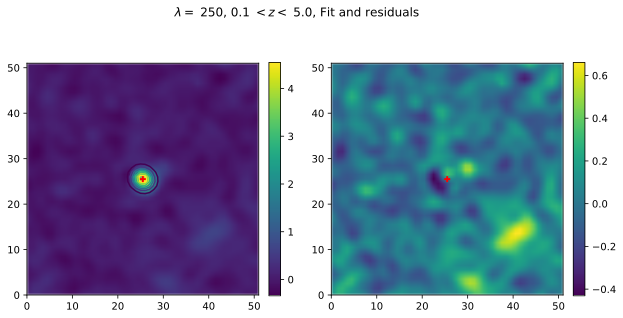

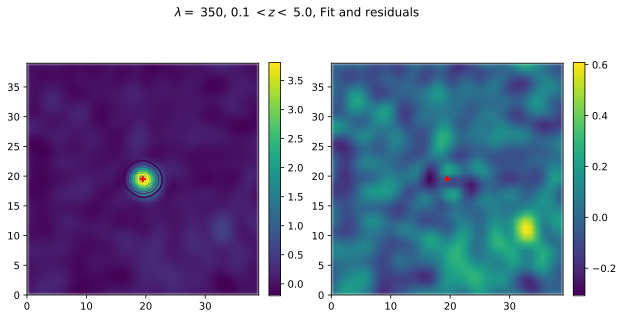

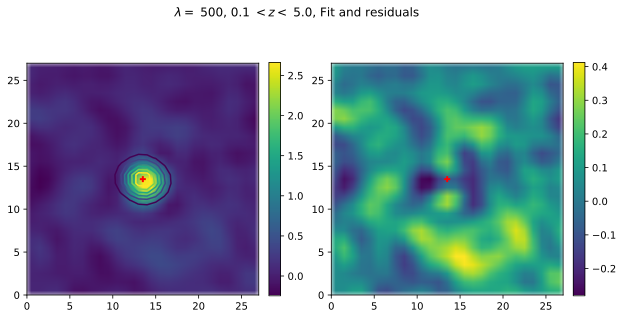

In [8]:
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
            p = anal.GaussFitTot(lambda_, idz, remove_max=0, remove_mean=False, plot=True)
            print lambda_, zbin[0], zbin[1], p.amplitude.value
#             plt.savefig('H-ATLAS_filtered_'+str(lambda_)+'_'+str(zbin[0])+'_'+str(zbin[1])+'.pdf')

In [11]:
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
            err = anal.GetTotBootstrapErrsFit2D(lambda_, idz, remove_mean=0, remove_max=0, nsim=500, nboot=2.)
            print lambda_, zbin[0], zbin[1], err

utils.py:1011: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cuts_id = np.random.choice(ncuts, size=ncuts/nboot)


250 0.1 5.0 0.228640195118
350 0.1 5.0 0.149179721594
500 0.1 5.0 0.136451055587


In [22]:
sum(anal.cuts[500][p][0].shape[0] for p in ['G9','G12','G15'])

8625

In [25]:
print anal.cuts[500]['G9'][0].shape[0]
print anal.cuts[500]['G12'][0].shape[0]
print anal.cuts[500]['G15'][0].shape[0]

3110
2905
2610
